## Outside of the Container:

In [80]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os
import shutil

In [90]:
def cropped_pc_from_bounds(pts: np.array, min_bounds: np.array, max_bounds: np.array):
    """
    Bounds a point cloud to a specified world boundary.

    Args:
      pts: A numpy array of shape (N, 3) representing the point cloud.
      min_bounds: A numpy array of shape (1, 3) representing the world bounds [x, y, z]
      max_bounds: A numpy array of shape (1, 3) representing the world bounds [x, y, z]

    Returns:
      A numpy array of shape (M, 3) representing the bounded point cloud,
      or None if no points remain within the bounds.
    """

    # Apply boolean mask to filter points within bounds
    valid = (
        (pts[:, 0] >= min_bounds[0])
        & (pts[:, 0] <= max_bounds[0])
        & (pts[:, 1] >= min_bounds[1])
        & (pts[:, 1] <= max_bounds[1])
        & (pts[:, 2] >= min_bounds[2])
        & (pts[:, 2] <= max_bounds[2])
    )
    pts_filtered = pts[valid]

    # Check if any points remain
    if not np.any(valid):
        print("no valid points")
        return None

    return pts_filtered

def crop_ply(file_key, bbox_dict):
  if file_key not in bbox_dict:
      print('wrong file name')
      return
  centroid = bbox_dict[file_key]['centroid']
  dims = bbox_dict[file_key]['dims']

  file_path = bbox_dict[file_key]['path']
  filename = os.path.basename(file_path)
  name, _ = os.path.splitext(filename)

  directory = os.path.dirname(file_path)

  cropped_pc_path = os.path.join(directory, f'{name}_cropped.ply')
  cropped_pc_np_path = os.path.join(directory, f'{name}_cropped.npy')

  bbox_dict[file_key]['name'] = name
  bbox_dict[file_key]['np_path'] = cropped_pc_np_path
  bbox_dict[file_key]['cropped_path'] = cropped_pc_path


  # Crop the point cloud
  min_bounds = [c - size/2 for (c, size) in zip(centroid, dims)]
  max_bounds = [c + size/2 for (c, size) in zip(centroid, dims)]

  xyz_min = np.minimum(min_bounds, max_bounds)
  xyz_max = np.maximum(min_bounds, max_bounds)

  pcd = o3d.io.read_point_cloud(file_path)
  cropped_point_cloud = pcd.crop(
    o3d.geometry.AxisAlignedBoundingBox(min_bound=xyz_min, max_bound=xyz_max)
  )

  # Save the cropped pc with color:
  o3d.io.write_point_cloud(cropped_pc_path, cropped_point_cloud)

  # Save just the points as a np file for
  np.save(cropped_pc_np_path, np.asarray(cropped_point_cloud.points))

  print("Saved both np and ply files!")
  return bbox_dict

def pc_from_np_array(pc_confs):
    # Create PointCloud object
  point_cloud = o3d.geometry.PointCloud()
  points = np.zeros((len(pc_confs), 3))
  points[:, 0] = pc_confs['x']
  points[:, 1] = pc_confs['y']
  points[:, 2] = pc_confs['z']
  point_cloud.points = o3d.utility.Vector3dVector(points)

  colors = np.zeros((len(pc_confs), 3))
  colors[:, 0] = pc_confs['r']
  colors[:, 1] = pc_confs['g']
  colors[:, 2] = pc_confs['b']
  point_cloud.colors = o3d.utility.Vector3dVector(colors)

  return point_cloud

In [96]:
bbox_dict = {"A":
            {"path": "/home/mmicatka/Documents/point_clouds/files/pointclouds/a_pc.ply",
             "centroid": [-0.00470451, 0.02, 0.43373715],
            "dims": [0.15, 0.13, 0.15]}}

bbox_dict = crop_ply("A", bbox_dict)

# copy files into tsgrasp dir
pc_dir = "/home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds"

for k, v in bbox_dict.items():
    try:
        shutil.copy(v["np_path"], pc_dir)
        name = v["name"]

         # these doesn't exist yet, but create the entry:
        v['pc_confs_path_np'] = os.path.join(pc_dir, f'{name}_cropped_confs.npy')
        v['grasps_path'] = os.path.join(pc_dir, f'{name}_cropped_grasps.npy')
        v['pc_confs_path'] = os.path.join(pc_dir, f'{name}_cropped_confs.ply')

    except Exception as ex:
        print(ex)

Saved both np and ply files!


In [95]:
for k, v in bbox_dict.items():
    print(k)
    for ki, vi in v.items():
        print("  ", ki, vi)

A
   path /home/mmicatka/Documents/point_clouds/files/pointclouds/a_pc.ply
   centroid [-0.00470451, 0.02, 0.43373715]
   dims [0.15, 0.13, 0.15]
   name a_pc
   np_path /home/mmicatka/Documents/point_clouds/files/pointclouds/a_pc_cropped.npy
   cropped_path /home/mmicatka/Documents/point_clouds/files/pointclouds/a_pc_cropped.ply
   pc_confs_path_np /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/a_pc_cropped_confs.npy
   grasps_path /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/a_pc_cropped_grasps.npy
   pc_confs_path /home/mmicatka/Documents/raven_manipulation/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/test_pointclouds/a_pc_cropped_confs.ply


## In Container

In [98]:
'''
(in /nodes)
`./run.sh`

Inside container:
cd grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/
jupyter notebook --ip 0.0.0.0  --allow-root
'''

'\n(in /nodes)\n`./run.sh`\n\nInside container:\ncd grasp_synth_ws/src/grasp_synthesis/src/grasp_synthesis/tsgrasp/\njupyter notebook --ip 0.0.0.0  --allow-root\n'

In [1]:
# Standard Library
import numpy as np
import torch
assert torch.cuda.is_available(), "cant access cuda. yikes"
from predict_grasps import GraspPredictor
import yaml

def model_metadata_from_yaml(yaml_file_path: str) -> dict:
    metadata = {}
    try:
        with open(yaml_file_path, "r", encoding="utf-8") as stream:
            metadata = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
    return metadata

# Create the predictor:
pkg_root = "/grasp_synth/grasp_synth_ws/src/grasp_synthesis/"
model_metadata = model_metadata_from_yaml(os.path.join(os.getcwd(), "models/tsgrasp_scene_1_frame/metadata.yaml"))
model_path = os.path.join(pkg_root, model_metadata["ckpt_path"])
grasp_predictor = GraspPredictor(model_metadata, False, pkg_root)

True

In [ ]:
# Load the points:
pc_dir = os.path.join(os.getcwd(), "test_pointclouds")
files = os.listdir(pc_dir)
npy_files = [file for file in files if file.endswith('.npy')]

grasp_dict = {}
for file in npy_files:
    key = os.path.splitext(file)[0]

    # Load the points
    full_file_name = os.path.join(pc_dir, file)
    cropped_points = np.load(full_file_name)

    # Run the detector:
    grasps, pc_confs = grasp_predictor.detect(cropped_points)

    # save the points
    filename = os.path.join(pc_dir, f"{key}_confs.npy")
    np.save(filename, pc_confs)

    # Save the conf array:
    filename = os.path.join(pc_dir, f"{key}_grasps.npy")
    confs = np.array([grasp.conf for grasp in grasps])
    np.save(filename, confs)

## Outside the Container


In [99]:
for k, v in bbox_dict.items():
    # load the pc_conf
    pc_confs_path  = v["pc_confs_path_np"]
    pc_confs = np.load(pc_confs_path)
    pcd = pc_from_np_array(pc_confs)

    # Write the pointcloud as a ply:
    o3d.io.write_point_cloud(v["pc_confs_path"], pcd)

    # load grasps
    grasps_path = v["grasps_path"]
    grasps = np.load(grasps_path)


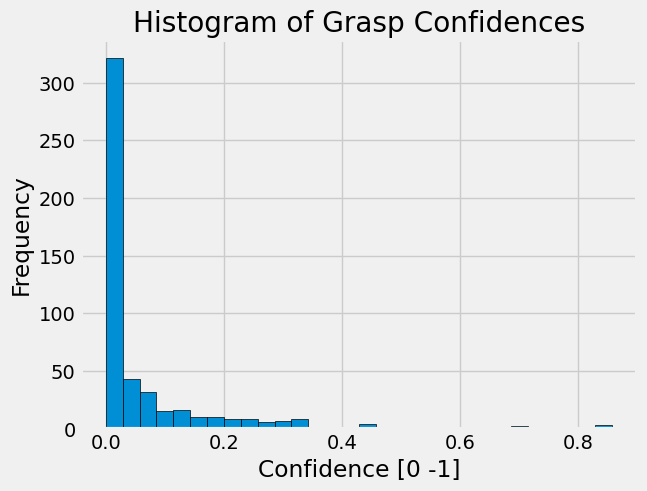

In [100]:

# Plot histogram
# Set style to use 538 color palette
plt.style.use('fivethirtyeight')

plt.hist(grasps, bins=30, edgecolor='black')

# Add labels and title
plt.xlabel('Confidence [0 -1]')
plt.ylabel('Frequency')
plt.title('Histogram of Grasp Confidences')

# Show plot
plt.show()
